Species Classification

0-funestus 1-gambiae 2-Anopheles_other 3-culex 4-All other

Author: Remus

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import re

# Read and export data from M1

In [2]:
xls = pd.ExcelFile('Master Data Sheet Organization.xlsx')
data_df = pd.read_excel(xls, 'Master Sheet - M1')
new_header = data_df.iloc[0] #grab the first row for the header
data_df = data_df[1:] #take the data less the header row
data_df.columns = new_header #set the header row as the df header
data_df = data_df.loc[(data_df['Picture?'] == 'Y')].reset_index(drop=True)
data_df.reset_index(drop=True, inplace=True)
data_df

0        NaN Country  District  Sentinel Site                 Date  \
0        6.0   Uganda    Soroti         Awoja  2021-08-13 00:00:00   
1        8.0   Uganda    Soroti         Awoja  2021-08-13 00:00:00   
2        9.0   Uganda    Soroti         Awoja  2021-08-13 00:00:00   
3       10.0   Uganda    Soroti         Awoja  2021-08-13 00:00:00   
4       11.0   Uganda    Soroti         Awoja  2021-08-13 00:00:00   
...      ...      ...       ...           ...                  ...   
1404  1646.0   Zambia    Matcha            B2  2021-05-10 00:00:00   
1405  1647.0   Zambia    Matcha            B2  2021-05-10 00:00:00   
1406  1648.0   Zambia    Matcha      Chidakwa  2021-05-10 00:00:00   
1407  1649.0   Zambia    Matcha      Chidakwa  2021-05-09 00:00:00   
1408  1650.0   Zambia    Matcha      Chidakwa  2021-05-09 00:00:00   

0    MOSQUITO ID (Team) Morph ID Genus Morph ID Species  \
0          U-SR-01-0006      Anopheles         funestus   
1          U-SR-01-0008      Anopheles         funestus   
2          U-SR-01-0009      Anopheles         funestus   
3          U-SR-01-0010      Anopheles         funestus   
4          U-SR-01-0011      Anopheles         funestus   
...                 ...            ...              ...   
1404       Z-MA-01-0295     Anopheles           gambiae   
1405       Z-MA-01-0296     Anopheles           rufipes   
1406       Z-MA-01-0297     Anopheles           rufipes   
1407       Z-MA-01-0298     Anopheles        longipalps   
1408       Z-MA-01-0299     Anopheles           rufipes   

0    PCR Number (Country Specific) PCR ID Genus PCR ID Species  \
0                              498          NaN            NaN   
1                              NaN    Anopheles       funestus   
2                              NaN          NaN            NaN   
3                              NaN    Anopheles       funestus   
4                              NaN    Anopheles       funestus   
...                            ...          ...            ...   
1404                     MI2100295          NaN            NaN   
1405                     MI2100296   Anopheles         gambiae   
1406                     MI2100297          NaN            NaN   
1407                     MI2100298          NaN            NaN   
1408                     MI2100299          NaN            NaN   

0    Sibling Species Picture? Prototype Abdomen Status  Sex Parity  \
0                NaN        Y      1409             SG    F    NaN   
1                 ss        Y       NaN             UF  NaN    NaN   
2                NaN        Y       NaN              G    F    NaN   
3                 ss        Y       NaN              G    F    NaN   
4                 ss        Y       NaN            NaN  NaN    NaN   
...              ...      ...       ...            ...  ...    ...   
1404             NaN        Y       NaN             UF    F    NaN   
1405      arabiensis        Y       NaN             UF    F    NaN   
1406             NaN        Y       NaN             UF    F    NaN   
1407             NaN        Y       NaN             UF    F    NaN   
1408             NaN        Y       NaN             UF    F    NaN   

0    Eliza Results   
0               NaN  
1               NEG  
2               NEG  
3               NEG  
4               NEG  
...             ...  
1404            NaN  
1405            NaN  
1406            NaN  
1407            NaN  
1408            NaN  

[1409 rows x 18 columns]

In [3]:
df_a = data_df[(data_df['Morph ID Genus'] == 'Anopheles') | (data_df['Morph ID Genus'] == 'anopheles') | (data_df['Morph ID Genus'] == 'Anopheles ')]
print(df_a.shape)
df_b = data_df[(data_df['Morph ID Genus'] == 'Culex')]
print(df_b.shape)
df_c = data_df[(data_df['Morph ID Genus'] != 'Culex') & (data_df['Morph ID Genus'] != 'Anopheles') & (data_df['Morph ID Genus'] != 'anopheles')& (data_df['Morph ID Genus'] != 'Anopheles ')]
print(df_c.shape)

(1000, 18)
(224, 18)
(185, 18)


In [4]:
# use PCR results if avaliable
df = pd.DataFrame()
ID = []
genus = []
species = []
for i in range(data_df.shape[0]):
    ID.append(data_df.loc[i,'MOSQUITO ID (Team)'])
    genus_name = data_df.loc[i,'Morph ID Genus']
    species_name = data_df.loc[i,'Morph ID Species']
    if genus_name == 'Anopheles' or genus_name == 'anopheles' or genus_name == 'Anopheles ':
        if pd.notna(data_df.loc[i,'PCR ID Genus']) == True:
            genus_name = data_df.loc[i,'PCR ID Genus']
        if pd.notna(data_df.loc[i,'PCR ID Species']) == True:
            species_name = data_df.loc[i,'PCR ID Species']
    genus.append(genus_name)
    species.append(species_name)
df['ID'] = ID
df['genus'] = genus
df['species'] = species
df = df.dropna(subset=['genus'],how='any').reset_index(drop=True)
df

ID       genus     species
0     U-SR-01-0006   Anopheles    funestus
1     U-SR-01-0008   Anopheles    funestus
2     U-SR-01-0009   Anopheles    funestus
3     U-SR-01-0010   Anopheles    funestus
4     U-SR-01-0011   Anopheles    funestus
...            ...         ...         ...
1350  Z-MA-01-0295  Anopheles      gambiae
1351  Z-MA-01-0296  Anopheles      gambiae
1352  Z-MA-01-0297  Anopheles      rufipes
1353  Z-MA-01-0298  Anopheles   longipalps
1354  Z-MA-01-0299  Anopheles      rufipes

[1355 rows x 3 columns]

In [5]:
print(len(df[df['genus'] == 'Mansonia']))

20


In [6]:
print(df[df['ID'] == 'G-TM-04-0107'])

               ID   genus species
944  G-TM-04-0107  Culex      NaN


In [7]:
df_with_label = pd.DataFrame()
label = []
for i in range(df.shape[0]):
    genus = df.loc[i,'genus']
    species = df.loc[i,'species']
    if genus == 'Anopheles' or genus == 'anopheles' or genus == 'Anopheles ':
        if species == 'funestus':
            label.append(0)
        elif species == 'gambiae' or species == 'Gambiae' or species == 'gambie':
            label.append(1)
        else:
            label.append(2)
    elif genus == "Culex" or genus == "Culex ":
        label.append(3)
    else:
        label.append(4)
        
df_with_label['ID'] = df['ID']
df_with_label['label'] = label
df_with_label

ID  label
0     U-SR-01-0006      0
1     U-SR-01-0008      0
2     U-SR-01-0009      0
3     U-SR-01-0010      0
4     U-SR-01-0011      0
...            ...    ...
1350  Z-MA-01-0295      1
1351  Z-MA-01-0296      1
1352  Z-MA-01-0297      2
1353  Z-MA-01-0298      2
1354  Z-MA-01-0299      2

[1355 rows x 2 columns]

In [8]:
 df_with_label[df_with_label['label'] == 4]

ID  label
146  U-SR-01-0198      4
201  U-SR-01-0276      4
238  U-SR-01-0359      4
241  U-SR-01-0365      4
242  U-SR-01-0366      4
243  U-SR-01-0367      4
244  U-SR-01-0368      4
245  U-SR-01-0369      4
246  U-SR-01-0370      4
247  U-SR-01-0371      4
248  U-SR-01-0372      4
249  U-SR-01-0373      4
250  U-SR-01-0374      4
421  U-SR-01-0627      4
422  U-SR-01-0628      4
423  U-SR-01-0629      4
424  U-SR-01-0630      4
445  U-SR-01-0711      4
446  U-SR-01-0712      4
450  U-SR-01-0716      4
993  G-TM-05-0001      4
994  G-TM-05-0002      4
995  G-TM-05-0003      4

In [9]:
df1 = df_with_label[df_with_label['label'] == 0]
df2 = df_with_label[df_with_label['label'] == 1]
df3 = df_with_label[df_with_label['label'] == 2]
df4 = df_with_label[df_with_label['label'] == 3]
df5 = df_with_label[df_with_label['label'] == 4]
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(441, 2)
(234, 2)
(325, 2)
(332, 2)
(23, 2)


In [11]:
print(df_with_label[df_with_label['ID'] == 'G-TM-02-0108'])

               ID  label
703  G-TM-02-0108      2


In [12]:
df1 = df1.sample(frac=1).reset_index(drop=True)
df2 = df2.sample(frac=1).reset_index(drop=True)
df3 = df3.sample(frac=1).reset_index(drop=True)
df4 = df4.sample(frac=1).reset_index(drop=True)
df5 = df5.sample(frac=1).reset_index(drop=True)
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(441, 2)
(234, 2)
(325, 2)
(332, 2)
(23, 2)


In [13]:
from sklearn.model_selection import train_test_split
train_data1, test_data1 = train_test_split(df1, test_size=0.15)
train_data2, test_data2 = train_test_split(df2, test_size=0.15)
train_data3, test_data3 = train_test_split(df3, test_size=0.15)
train_data4, test_data4 = train_test_split(df4, test_size=0.15)
train_data5, test_data5 = train_test_split(df5, test_size=0.15)

In [14]:
train_data = pd.concat([train_data1, train_data2, train_data3, train_data4, train_data5], ignore_index=True)
test_data = pd.concat([test_data1, test_data2, test_data3, test_data4, test_data5], ignore_index=True)
print(train_data.shape)
print(test_data.shape)
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

(1149, 2)
(206, 2)


In [43]:
test_data.head()

ID  label
0  U-SR-01-0603      0
1  Z-MA-01-0039      2
2  G-TM-02-0113      1
3  U-SR-01-0314      0
4  Z-MA-01-0107      2

In [ ]:
train_data.to_csv('data/CV_1_train_path_3_1.csv', index = False)

In [17]:
from torchvision import transforms
mosquito_transforms = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize([240,240]),
    transforms.ToTensor()
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [18]:
from PIL import Image, ImageOps
def make_data(d):
    data_path = "M1_Database"
    data = []
    label = []
    paths = []
    F_count = 0
    G_count = 0
    Aother_count = 0
    C_count = 0
    Other_count = 0
    df = pd.DataFrame()
    for i in range(d.shape[0]):
        for f in os.listdir(data_path):
            if re.match(d.loc[i,'ID'], f) and f.endswith('a.jpg'):
                path = os.path.join(data_path, f)
                paths.append(path)
                image = Image.open(path)
                #image = ImageOps.exif_transpose(image)
                image = mosquito_transforms(image)
                data.append(image)
                if d.loc[i,'label'] == 0:
                    label.append(0)
                    F_count += 1
                elif d.loc[i,'label'] == 1:
                    label.append(1)
                    G_count += 1
                elif d.loc[i,'label'] == 2:
                    label.append(2)
                    Aother_count += 1    
                elif d.loc[i,'label'] == 3:
                    label.append(3)
                    C_count += 1
                elif d.loc[i,'label'] == 4:
                    label.append(4)
                    Other_count += 1
    stacked_data = torch.stack(data)
    df['path'] = paths
    df['label'] = label 
    print("Counts:", "AF:", F_count, "AG:", G_count, "A_other:", Aother_count, "Culex:", C_count, "Other:", Other_count) 
                
    return stacked_data, label, df

In [19]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle = True)
target = train_data.loc[:,'label']
count = 1
for train_index, valid_index in skf.split(train_data, target):
    train = train_data.loc[train_index,:]
    valid = train_data.loc[valid_index,:]
    train = train.reset_index(drop=True)
    valid = valid.reset_index(drop=True)
    print("Validation: ")
    d, label, path_df = make_data(valid)
    torch.save(d,f"data/species/CV_2_M1/val_data_fold{count}.pt")
    torch.save(torch.tensor(label),f"data/species/CV_2_M1/val_label_fold{count}.pt")
    # path_df.to_csv(f"data/species/CV_2_M1/val_datapath_fold{count}.csv", index = False)
    print("Train: ")
    d2, label2, path_df2 = make_data(train)
    torch.save(d2,f"data/species/CV_2_M1/train_data_fold{count}.pt")
    torch.save(torch.tensor(label2),f"data/species/CV_2_M1/train_label_fold{count}.pt")
    # path_df2.to_csv(f"data/species/CV_2_M1/train_datapath_fold{count}.csv", index = False)
    count += 1

Validation: 
Counts: AF: 214 AG: 101 A_other: 116 Culex: 175 Other: 12
Train: 
Counts: AF: 886 AG: 400 A_other: 455 Culex: 680 Other: 43
Validation: 
Counts: AF: 206 AG: 80 A_other: 118 Culex: 171 Other: 12
Train: 
Counts: AF: 894 AG: 421 A_other: 453 Culex: 684 Other: 43
Validation: 
Counts: AF: 213 AG: 127 A_other: 111 Culex: 170 Other: 11
Train: 
Counts: AF: 887 AG: 374 A_other: 460 Culex: 685 Other: 44
Validation: 
Counts: AF: 245 AG: 97 A_other: 103 Culex: 167 Other: 12
Train: 
Counts: AF: 855 AG: 404 A_other: 468 Culex: 688 Other: 43
Validation: 
Counts: AF: 222 AG: 96 A_other: 123 Culex: 172 Other: 8
Train: 
Counts: AF: 878 AG: 405 A_other: 448 Culex: 683 Other: 47


In [20]:
d, label, path_df = make_data(test_data)

Counts: AF: 181 AG: 76 A_other: 70 Culex: 150 Other: 12


In [21]:
print(d.shape)

torch.Size([489, 3, 240, 240])


In [50]:
path_df.to_csv('data/species/CV_1_M1/test_datapath.csv', index = False)

In [51]:
print('Test min=%.3f, max=%.3f' % (np.array(d).min(), np.array(d).max()))

Test min=0.000, max=1.000


In [22]:
torch.save(d,"data/species/CV_2_M1/test_data.pt")
torch.save(torch.tensor(label),"data/species/CV_2_M1/test_label.pt")

# Read and export from M2

In [16]:
l = np.load("data/gender/CV_1_M2/test_label.npy", allow_pickle=True)
print(l)
l = l.item()
torch.Tensor(l['label'])

{'label': [3, 3, 3, 3, 3, 3, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1], 'abdomen': [3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], 'gender': [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1

tensor([3., 3., 3., 3., 3., 3., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 3., 3., 3., 1., 1., 1.,
        3., 3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 2., 2., 2., 3., 3., 3., 3., 3., 3., 1., 1., 1.,
        3., 3., 3., 1., 1., 1., 1., 1., 1., 3., 3., 3., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 3., 3., 3., 1., 1., 1., 1., 1., 1., 3., 3., 3., 2., 2., 2.,
        1., 1., 1., 1., 1., 1.])

In [23]:
xls = pd.ExcelFile('Master Data Sheet Organization.xlsx')
data_df = pd.read_excel(xls, 'Master Sheet - M2')
new_header = data_df.iloc[0] #grab the first row for the header
data_df = data_df[1:] #take the data less the header row
data_df.columns = new_header #set the header row as the df header
data_df.reset_index(drop=True, inplace=True)
data_df

0   mosquito_id Country    City     Site                Date   \
0         G031B   Uganda  Bugiri  Buboki  2022-04-02 00:00:00   
1         G032B   Uganda  Bugiri  Buboki  2022-04-02 00:00:00   
2         G033B   Uganda  Bugiri  Buboki  2022-04-02 00:00:00   
3         G034B   Uganda  Bugiri  Buboki  2022-04-02 00:00:00   
4         B035B   Uganda  Bugiri  Buboki  2022-04-02 00:00:00   
..          ...      ...     ...     ...                  ...   
709         NaN      NaN     NaN     NaN                  NaN   
710         NaN      NaN     NaN     NaN                  NaN   
711         NaN      NaN     NaN     NaN                  NaN   
712         NaN      NaN     NaN     NaN                  NaN   
713         NaN      NaN     NaN     NaN                  NaN   

0     specimen_image_1   specimen_image_2   specimen_image_3 morph_id_genus  \
0    1648900605929.jpg  1648900637908.jpg  1648900654087.jpg      Anopheles   
1    1648900707180.jpg  1648900718477.jpg  1648900736152.jpg      Anopheles   
2    1648900875092.jpg  1648900888835.jpg  1648900905444.jpg      Anopheles   
3    1648900946763.jpg  1648900961718.jpg  1648900978547.jpg      Anopheles   
4    1648901102036.jpg  1648901120450.jpg  1648901136984.jpg      Anopheles   
..                 ...                ...                ...            ...   
709  1643193598508.jpg  1643193634018.jpg  1643193701849.jpg      Anopheles   
710  1643192970690.jpg  1643193019263.jpg  1643193065582.jpg      Anopheles   
711  1643193284792.jpg  1643193320535.jpg  1643193372510.jpg      Anopheles   
712  1642774690032.jpg  1642774707378.jpg  1642774718884.jpg      Anopheles   
713  1642522324618.jpg  1642522874070.png  1642522881150.jpg       Mansonia   

0   morph_id_genus_other  ... pcr_present pcr_id_genus pcr_id_genus_other  \
0                    NaN  ...       later          NaN                NaN   
1                    NaN  ...       later          NaN                NaN   
2                    NaN  ...       later          NaN                NaN   
3                    NaN  ...       later          NaN                NaN   
4                    NaN  ...       later          NaN                NaN   
..                   ...  ...         ...          ...                ...   
709                   \n  ...       later           \n                 \n   
710                   \n  ...       later           \n                 \n   
711                   \n  ...       later           \n                 \n   
712                   \n  ...          no           \n                 \n   
713                   \n  ...          no           \n                 \n   

0   pcr_id_aedes_species pcr_id_anopheles_species pcr_id_species_other  \
0                    NaN                      NaN                  NaN   
1                    NaN                      NaN                  NaN   
2                    NaN                      NaN                  NaN   
3                    NaN                      NaN                  NaN   
4                    NaN                      NaN                  NaN   
..                   ...                      ...                  ...   
709                   \n                       \n                   \n   
710                   \n                       \n                   \n   
711                   \n                       \n                   \n   
712                   \n                       \n                   \n   
713                   \n                       \n                   \n   

0   pcr_id_sibling  additional_note  \
0              NaN              NaN   
1              NaN              NaN   
2              NaN              NaN   
3              NaN              NaN   
4              NaN              NaN   
..             ...              ...   
709             \n               Na   
710             \n              NaN   
711             \n               Na   
712             \n              NaN   
713             \n  This is

In [24]:
# hold out test set
hold_out_df = pd.read_excel(xls, 'Hold out test set data')
hold_out_df = hold_out_df.dropna(subset=['specimen_image_1'])
hold_out_df.reset_index(drop=True, inplace=True)
hold_out_df

Unnamed: 0 Country  District  Sentinel Site       Date mosquito_id  \
0           524   Uganda    Soroti         Awoja 2022-03-30       G438M   
1           562   Uganda    Soroti         Awoja 2022-03-30       Bz_45   
2           158   Uganda    Bugiri       Bubwoki 2022-04-02       G042B   
3             7   Uganda    Bugiri        Buboki 2022-04-02       G039B   
4           116   Uganda    Bugiri        Buboki 2022-04-02       G010B   
..          ...      ...       ...           ...        ...         ...   
129         639   Zambia     Choma           Mrt 2022-03-22         Z02   
130         632   Zambia     Choma           Mrt 2022-03-23       Bz_32   
131         636   Zambia     Choma           Mrt 2022-03-22         Z04   
132         560   Uganda    Soroti         Awoja 2022-03-30       Bz_43   
133         638   Zambia     Choma           Mrt 2022-03-22         Z05   

    Morph ID Genus Morph ID Species Abdomen Status Sex   specimen_image_1  \
0        Anopheles          gambiae             UF   F  1648645240171.jpg   
1        Anopheles          gambiae             UF   F  1648039529855.jpg   
2        Anopheles          gambiae             UF   F  1648901812226.jpg   
3        Anopheles          gambiae             UF   F  1648901236439.jpg   
4        Anopheles          gambiae             UF   F  1648901867553.jpg   
..             ...              ...            ...  ..                ...   
129      Anopheles          rufipes             FF   F  1647981594634.jpg   
130      Anopheles          rufipes             UF   F  1648034185845.jpg   
131      Anopheles          rufipes             UF   F  1647980960907.jpg   
132      Anopheles          rufipes             UF   F  1648039194566.jpg   
133      Anopheles          rufipes             FF   F  1647981415362.jpg   

      specimen_image_2   specimen_image_3         gen_spe_sex_abd  \
0    1648645258515.jpg  1648645278223.jpg  Anopheles_gambiae_F_UF   
1    1648039540482.jpg  1648039560932.jpg  Anopheles_gambiae_F_UF   
2    1648901830485.jpg  1648901849038.jpg  Anopheles_gambiae_F_UF   
3    1648901249224.jpg  1648901265652.jpg  Anopheles_gambiae_F_UF   
4    1648901882829.jpg  1648901895352.jpg  Anopheles_gambiae_F_UF   
..                 ...                ...                     ...   
129  1647981611778.jpg  1647981695391.jpg  Anopheles_rufipes_F_FF   
130  1648034193946.jpg  1648034216273.jpg  Anopheles_rufipes_F_UF   
131  1647980977318.jpg  1647981004699.jpg  Anopheles_rufipes_F_UF   
132  1648039224840.jpg  1648039243832.jpg  Anopheles_rufipes_F_UF   
133  1647981433670.jpg  1647981465104.jpg  Anopheles_rufipes_F_FF   

             gen_spe_sex      gen_sex     gen_sex_abd  
0    Anopheles_gambiae_F  Anopheles_F  Anopheles_F_UF  
1    Anopheles_gambiae_F  Anopheles_F  Anopheles_F_UF  
2    Anopheles_gambiae_F  Anopheles_F  Anopheles_F_UF  
3    Anopheles_gambiae_F  Anopheles_F  Anopheles_F_UF  
4    Anopheles_gambiae_F  Anopheles_F  Anopheles_F_UF  
..                   ...          ...             ...  
129  Anopheles_rufipes_F  Anopheles_F  Anopheles_F_FF  
130  Anopheles_rufipes_F  Anopheles_F  Anopheles_F_UF  
131  Anopheles_rufipes_F  Anopheles_F  Anopheles_F_UF  
132  Anopheles_rufipes_F  Anopheles_F  Anopheles_F_UF  
133  Anopheles_rufipes_F  Anopheles_F  Anopheles_F_FF  

[134 rows x 17 columns]

In [10]:
hold_out_list = []
for i in range(len(hold_out_df)):
    hold_out_list.append(hold_out_df.loc[i, "specimen_image_1"])
    hold_out_list.append(hold_out_df.loc[i, "specimen_image_2"])
    hold_out_list.append(hold_out_df.loc[i, "specimen_image_3"])
len(hold_out_list)

402

In [11]:
len(os.listdir('holdout'))

1435

In [13]:
import shutil
for item in os.listdir('holdout'):
    if item not in hold_out_list:
        shutil.move(f"holdout/{item}", f"temp/{item}")

In [18]:
count = 0
for item in hold_out_list:
    if item in os.listdir('M2_Database'):
        #shutil.move(f"M2_Database/{item}", f"holdout/{item}") 
        count += 1
print(count)

0


In [83]:
data_df.drop(data_df[data_df['specimen_characteristics'] == "O"].index, inplace = True)

In [25]:
data_df.reset_index(drop=True, inplace=True)
data_df.shape

(714, 28)

In [26]:
label = []
for i in range(data_df.shape[0]):
    genus = data_df.loc[i,'morph_id_genus']
    species = data_df.loc[i,'morph_id_anopheles_species']
    if genus == 'Anopheles' or genus == 'anopheles' or genus == 'Anopheles ':
        if species == 'funestus':
            label.append(0)
        elif species == 'gambiae' or species == 'Gambiae' or species == 'gambie':
            label.append(1)
        else:
            label.append(2)
    elif genus == "Culex" or genus == "culex ":
        label.append(3)
    else:
        label.append(4)
data_df["label"] = label
data_df

0   mosquito_id Country    City     Site                Date   \
0         G031B   Uganda  Bugiri  Buboki  2022-04-02 00:00:00   
1         G032B   Uganda  Bugiri  Buboki  2022-04-02 00:00:00   
2         G033B   Uganda  Bugiri  Buboki  2022-04-02 00:00:00   
3         G034B   Uganda  Bugiri  Buboki  2022-04-02 00:00:00   
4         B035B   Uganda  Bugiri  Buboki  2022-04-02 00:00:00   
..          ...      ...     ...     ...                  ...   
709         NaN      NaN     NaN     NaN                  NaN   
710         NaN      NaN     NaN     NaN                  NaN   
711         NaN      NaN     NaN     NaN                  NaN   
712         NaN      NaN     NaN     NaN                  NaN   
713         NaN      NaN     NaN     NaN                  NaN   

0     specimen_image_1   specimen_image_2   specimen_image_3 morph_id_genus  \
0    1648900605929.jpg  1648900637908.jpg  1648900654087.jpg      Anopheles   
1    1648900707180.jpg  1648900718477.jpg  1648900736152.jpg      Anopheles   
2    1648900875092.jpg  1648900888835.jpg  1648900905444.jpg      Anopheles   
3    1648900946763.jpg  1648900961718.jpg  1648900978547.jpg      Anopheles   
4    1648901102036.jpg  1648901120450.jpg  1648901136984.jpg      Anopheles   
..                 ...                ...                ...            ...   
709  1643193598508.jpg  1643193634018.jpg  1643193701849.jpg      Anopheles   
710  1643192970690.jpg  1643193019263.jpg  1643193065582.jpg      Anopheles   
711  1643193284792.jpg  1643193320535.jpg  1643193372510.jpg      Anopheles   
712  1642774690032.jpg  1642774707378.jpg  1642774718884.jpg      Anopheles   
713  1642522324618.jpg  1642522874070.png  1642522881150.jpg       Mansonia   

0   morph_id_genus_other  ... pcr_id_genus pcr_id_genus_other  \
0                    NaN  ...          NaN                NaN   
1                    NaN  ...          NaN                NaN   
2                    NaN  ...          NaN                NaN   
3                    NaN  ...          NaN                NaN   
4                    NaN  ...          NaN                NaN   
..                   ...  ...          ...                ...   
709                   \n  ...           \n                 \n   
710                   \n  ...           \n                 \n   
711                   \n  ...           \n                 \n   
712                   \n  ...           \n                 \n   
713                   \n  ...           \n                 \n   

0   pcr_id_aedes_species pcr_id_anopheles_species pcr_id_species_other  \
0                    NaN                      NaN                  NaN   
1                    NaN                      NaN                  NaN   
2                    NaN                      NaN                  NaN   
3                    NaN                      NaN                  NaN   
4                    NaN                      NaN                  NaN   
..                   ...                      ...                  ...   
709                   \n                       \n                   \n   
710                   \n                       \n                   \n   
711                   \n                       \n                   \n   
712                   \n                       \n                   \n   
713                   \n                       \n                   \n   

0   pcr_id_sibling  additional_note  \
0              NaN              NaN   
1              NaN              NaN   
2              NaN              NaN   
3              NaN              NaN   
4              NaN              NaN   
..             ...              ...   
709             \n               Na   
710             \n              NaN   
711             \n               Na   
712             \n              NaN   
713             \n  This is a test    

0                                   PARENT_KEY  \
0    uuid:cd9fe629-f8a5-4dc0-8e7e-2eee17bf50b9   
1    uuid:cd9fe629-f8a5-4dc0-8e

In [27]:
# df1 = data_df[data_df['specimen_characteristics'] == 'SG']
# df2 = data_df[data_df['specimen_characteristics'] == 'G']
# df3 = data_df[data_df['specimen_characteristics'] == 'UF']
# df4 = data_df[data_df['specimen_characteristics'] == 'FF']

# species
df1 = data_df[data_df['label'] == 0]
df2 = data_df[data_df['label'] == 1]
df3 = data_df[data_df['label'] == 2]
df4 = data_df[data_df['label'] == 3]
df5 = data_df[data_df['label'] == 4]

# # sex
# df1 = data_df[data_df['specimen_gender'] == 'F']
# df2 = data_df[data_df['specimen_gender'] == 'M']

print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(238, 29)
(223, 29)
(37, 29)
(213, 29)
(3, 29)


In [101]:
# many UF only select 50 of those 
df1 = df1.sample(n=200).reset_index(drop=True)

In [28]:
df1 = df1.sample(frac=1).reset_index(drop=True)
df2 = df2.sample(frac=1).reset_index(drop=True)
df3 = df3.sample(frac=1).reset_index(drop=True)
df4 = df4.sample(frac=1).reset_index(drop=True)
df5 = df5.sample(frac=1).reset_index(drop=True)
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)

(238, 29)
(223, 29)
(37, 29)
(213, 29)
(3, 29)


In [29]:
from sklearn.model_selection import train_test_split
train_data1, test_data1 = train_test_split(df1, test_size=0.15)
train_data2, test_data2 = train_test_split(df2, test_size=0.15)
train_data3, test_data3 = train_test_split(df3, test_size=0.15)
train_data4, test_data4 = train_test_split(df4, test_size=0.15)
train_data5, test_data5 = train_test_split(df5, test_size=0.15)
#print(train_data5.shape)

In [30]:
train_data = pd.concat([train_data1, train_data2, train_data3, train_data4, train_data5], ignore_index=True)
test_data = pd.concat([test_data1, test_data2, test_data3, test_data4, test_data5], ignore_index=True)
print(train_data.shape)
print(test_data.shape)
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

(605, 29)
(109, 29)


In [105]:
from torchvision import transforms
mosquito_transforms = transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize([299,299]),
    transforms.ToTensor(),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [31]:
from PIL import Image, ImageOps
def make_new_data(d):
    data_path = "M2_Database"
    data = []
    label = []
    paths = []
    abdomen_status = []
    sex = []
    F_count = 0
    G_count = 0
    Aother_count = 0
    C_count = 0
    Other_count = 0
    SG_count = 0
    GG_count = 0
    UF_count = 0
    FF_count = 0
    male_count = 0 
    female_count = 0
    df = pd.DataFrame()
    for i in range(d.shape[0]):
        list_specimen = []
        list_specimen.append(d.loc[i,'specimen_image_1'])
        list_specimen.append(d.loc[i,'specimen_image_2'])
        list_specimen.append(d.loc[i,'specimen_image_3'])
        for specimen in list_specimen:
            if specimen in os.listdir(data_path):
                path = os.path.join(data_path, specimen)
                paths.append(path)
                image = Image.open(path)
                #image = ImageOps.exif_transpose(image)
                image = mosquito_transforms(image)
                data.append(image)
                if d.loc[i,'label'] == 0:
                    label.append(0)
                    F_count += 1
                elif d.loc[i,'label'] == 1:
                    label.append(1)
                    G_count += 1
                elif d.loc[i,'label'] == 2:
                    label.append(2)
                    Aother_count += 1    
                elif d.loc[i,'label'] == 3:
                    label.append(3)
                    C_count += 1
                elif d.loc[i,'label'] == 4:
                    label.append(4)
                    Other_count += 1
                if d.loc[i,'specimen_characteristics'] == "SG":
                    abdomen_status.append(0)
                    SG_count += 1
                if d.loc[i,'specimen_characteristics'] == "G":
                    abdomen_status.append(1)
                    GG_count += 1
                if d.loc[i,'specimen_characteristics'] == "UF":
                    abdomen_status.append(2)
                    UF_count += 1
                if d.loc[i,'specimen_characteristics'] == "FF":
                    abdomen_status.append(3)
                    FF_count += 1
                if d.loc[i,'specimen_gender'] == "F":
                    sex.append(0)
                    female_count += 1
                if d.loc[i,'specimen_gender'] == "M":
                    sex.append(1)
                    male_count += 1
                    
    stacked_data = torch.stack(data)
    df['path'] = paths
    df['label'] = label
    df['abdomen'] = abdomen_status
    df['gender'] = sex 
    print("F_count: ", F_count)
    print("G_count: ", G_count)
    print("Aother_count: ", Aother_count)
    print("C_count: ", C_count)
    print("Other_count: ", Other_count)
    print("SG_count: ", SG_count)
    print("GG_count: ", GG_count)
    print("UF_count: ", UF_count)
    print("FF_count: ", FF_count)
    print("female_count: ", female_count)
    print("male_count: ", male_count)
    d1={'label':label, 'abdomen':abdomen_status, 'gender':sex}
                
    return stacked_data, d1, df

In [60]:
train_data

0   mosquito_id  Country    City      Site                Date   \
0         C272B    Uganda  Bugiri  Bubwoki  2022-04-02 00:00:00   
1         F101m    Uganda  Soroti   Madera  2022-03-28 00:00:00   
2         G428M    Uganda  Soroti    Awoja  2022-03-30 00:00:00   
3          Bc41  Zambia\n   Choma      Mrt  2022-03-23 00:00:00   
4         C197B    Uganda  Bugiri   Buboki  2022-04-02 00:00:00   
..          ...       ...     ...      ...                  ...   
600       G012B    Uganda  Bugiri  Bubwoki  2022-04-02 00:00:00   
601         NaN       NaN     NaN      NaN                  NaN   
602       G017B    Uganda  Bugiri  Bubwoki  2022-04-02 00:00:00   
603       F073m    Uganda  Soroti   Madera  2022-03-28 00:00:00   
604       G111B    Uganda  Bugiri  Bubwoki  2022-04-02 00:00:00   

0     specimen_image_1   specimen_image_2   specimen_image_3 morph_id_genus  \
0    1648910537734.jpg  1648910546189.jpg  1648910556367.jpg          Culex   
1    1648719659715.jpg  1648719675275.jpg  1648719686718.jpg      Anopheles   
2    1648647486593.jpg  1648647502578.jpg  1648647512846.jpg      Anopheles   
3    1648035946634.jpg  1648035956212.jpg  1648035963807.jpg          Culex   
4    1648906028934.jpg  1648906045986.jpg  1648906063447.jpg          Culex   
..                 ...                ...                ...            ...   
600  1648900800505.jpg  1648900821505.jpg  1648900835657.jpg      Anopheles   
601  1643192970690.jpg  1643193019263.jpg  1643193065582.jpg      Anopheles   
602  1648901314996.jpg  1648901328378.jpg  1648901341048.jpg      Anopheles   
603  1648709837933.jpg  1648709854602.jpg  1648709873135.jpg      Anopheles   
604  1648903926682.jpg  1648903956233.jpg  1648903969219.jpg      Anopheles   

0   morph_id_genus_other  ... pcr_id_genus pcr_id_genus_other  \
0                    NaN  ...          NaN                NaN   
1                    NaN  ...          NaN                NaN   
2                    NaN  ...          NaN                NaN   
3                    NaN  ...          NaN                NaN   
4                    NaN  ...          NaN                NaN   
..                   ...  ...          ...                ...   
600                  NaN  ...          NaN                NaN   
601                   \n  ...           \n                 \n   
602                  NaN  ...          NaN                NaN   
603                  NaN  ...          NaN                NaN   
604                  NaN  ...          NaN                NaN   

0   pcr_id_aedes_species pcr_id_anopheles_species pcr_id_species_other  \
0                    NaN                      NaN                  NaN   
1                    NaN                      NaN                  NaN   
2                    NaN                      NaN                  NaN   
3                    NaN                      NaN                  NaN   
4                    NaN                      NaN                  NaN   
..                   ...                      ...                  ...   
600                  NaN                      NaN                  NaN   
601                   \n                       \n                   \n   
602                  NaN                      NaN                  NaN   
603                  NaN                      NaN                  NaN   
604                  NaN                      NaN                  NaN   

0   pcr_id_sibling additional_note                                 PARENT_KEY  \
0              NaN             NaN  uuid:143162f6-75fe-4410-bb67-3230860bdf41   
1              NaN             NaN  uuid:fc19e6f5-cec9-4db6-9617-4fe7b35776b3   
2              NaN             NaN  uuid:5ad260db-ac94-4aee-bcb1-89ea6a945956   
3              NaN             NaN  uuid:b0c1d996-ee15-4e2b-9d11-3e69cd229839   
4              NaN             NaN  uuid:cd9fe629-f8a5-4dc0-8e7e-2eee17bf50b9   
..             ...             ...                                        ...   
600      

In [32]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle = True)
target = train_data.loc[:,'label']
count = 1
for train_index, valid_index in skf.split(train_data, target):
    print(f"Fold{count}: ")
    train = train_data.loc[train_index,:]
    valid = train_data.loc[valid_index,:]
    train = train.reset_index(drop=True)
    valid = valid.reset_index(drop=True)
    print("Validation: ")
    d, dic1, path_df = make_new_data(valid)
    torch.save(d,f"data/species/CV_2_M2/val_data_fold{count}.pt")
    np.save(f"data/species/CV_2_M2/val_label_fold{count}.npy", dic1)
    # path_df.to_csv(f"data/species/CV_2_M2/val_datapath_fold{count}.csv", index = False)
    print("Train: ")
    d2, dic2, path_df2 = make_new_data(train)
    torch.save(d2,f"data/species/CV_2_M2/train_data_fold{count}.pt")
    np.save(f"data/species/CV_2_M2/train_label_fold{count}.npy", dic2)
    # path_df2.to_csv(f"data/species/CV_2_M2/train_datapath_fold{count}.csv", index = False)
    count += 1

Fold1: 
Validation: 


/home/veccam/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


F_count:  96
G_count:  99
Aother_count:  12
C_count:  87
Other_count:  0
SG_count:  9
GG_count:  12
UF_count:  264
FF_count:  9
female_count:  249
male_count:  45
Train: 
F_count:  377
G_count:  381
Aother_count:  60
C_count:  342
Other_count:  3
SG_count:  42
GG_count:  54
UF_count:  1022
FF_count:  45
female_count:  938
male_count:  225
Fold2: 
Validation: 
F_count:  89
G_count:  99
Aother_count:  15
C_count:  96
Other_count:  0
SG_count:  9
GG_count:  18
UF_count:  254
FF_count:  18
female_count:  233
male_count:  66
Train: 
F_count:  384
G_count:  381
Aother_count:  57
C_count:  333
Other_count:  3
SG_count:  42
GG_count:  48
UF_count:  1032
FF_count:  36
female_count:  954
male_count:  204
Fold3: 
Validation: 
F_count:  96
G_count:  84
Aother_count:  18
C_count:  87
Other_count:  0
SG_count:  12
GG_count:  6
UF_count:  258
FF_count:  9
female_count:  237
male_count:  48
Train: 
F_count:  377
G_count:  396
Aother_count:  54
C_count:  342
Other_count:  3
SG_count:  39
GG_count:  60


In [33]:
d, dic, path_df = make_new_data(test_data)

F_count:  87
G_count:  90
Aother_count:  15
C_count:  81
Other_count:  0
SG_count:  15
GG_count:  15
UF_count:  225
FF_count:  18
female_count:  228
male_count:  45


In [34]:
print(d.shape)

torch.Size([273, 3, 240, 240])


In [35]:
path_df.to_csv('data/species/CV_2_M2/test_datapath.csv', index = False)

In [36]:
print('Test min=%.3f, max=%.3f' % (np.array(d).min(), np.array(d).max()))

Test min=0.016, max=0.918


In [37]:
torch.save(d,"data/species/CV_2_M2/test_data.pt")
np.save("data/species/CV_2_M2/test_label.npy", dic)

# Read all data

In [ ]:
# if train
# new_data means part of data from March trip
# other_data means data from older large database taken with DLSR camera
# because we have so few image in "other" class. We can ignore them for now.
train_data = torch.load("species/data/train_data_fold2.pt")
train_label = torch.load("species/data/train_label_fold2.pt")
test_data = torch.load("species/data/valid_data_fold2.pt")
test_label = torch.load("species/data/valid_label_fold2.pt")
train_new_data = torch.load("species/data/train_new_data_fold2.pt")
train_new_label = torch.load("species/data/train_new_label_fold2.pt")
test_new_data = torch.load("species/data/valid_new_data_fold2.pt")
test_new_label = torch.load("species/data/valid_new_label_fold2.pt")
train_other_data = torch.load("species/data/train_other_data.pt")
train_other_label = torch.load("species/data/train_other_label.pt")
test_other_data = torch.load("species/data/test_other_data.pt")
test_other_label = torch.load("species/data/test_other_label.pt")

In [ ]:
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)
print(train_new_data.shape)
print(train_new_label.shape)
print(test_new_data.shape)
print(test_new_label.shape)
print(train_other_data.shape)
print(train_other_label.shape)
print(test_other_data.shape)
print(test_other_label.shape)

torch.Size([2320, 3, 299, 299])
torch.Size([2320])
torch.Size([567, 3, 299, 299])
torch.Size([567])
torch.Size([810, 3, 299, 299])
torch.Size([810])
torch.Size([204, 3, 299, 299])
torch.Size([204])
torch.Size([284, 3, 299, 299])
torch.Size([284])
torch.Size([55, 3, 299, 299])
torch.Size([55])


In [ ]:
# if test
test_data = torch.load("species/data/Species_test_data2.pt")
test_label = torch.load("species/data/Species_test_label2.pt")
test_new_data = torch.load("species/data/test_new_data.pt")
test_new_label = torch.load("species/data/test_new_label.pt")
test_other_data = torch.load("species/data/test_other_data.pt")
test_other_label = torch.load("species/data/test_other_label.pt")

In [ ]:
train_data = torch.cat((train_data, train_new_data, train_other_data), 0)
print(train_data.shape)

torch.Size([3414, 3, 299, 299])


In [ ]:
#train_label = torch.cat((train_label, train_new_label, train_other_label), 0)
test_data = torch.cat((test_data, test_new_data, test_other_data), 0)
test_label = torch.cat((test_label, test_new_label, test_other_label), 0)

In [ ]:
print(test_data.shape)

torch.Size([1042, 3, 299, 299])


In [ ]:
torch.save(train_data,"species/data/train_whole_data_fold2.pt")
torch.save(train_label,"species/data/train_whole_label_fold2.pt")
torch.save(test_data,"species/data/val_whole_data_fold2.pt")
torch.save(test_label,"species/data/val_whole_label_fold2.pt")

# Train and test 

In [ ]:
train_data = torch.load("species/data/train_whole_data_fold2.pt")
train_label = torch.load("species/data/train_whole_label_fold2.pt")
test_data = torch.load("species/data/val_whole_data_fold2.pt")
test_label = torch.load("species/data/val_whole_label_fold2.pt")

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print ("running on the GPU")
else:
    device = torch.device("cpu")
    print ("running on the cpu")
print(torch.cuda.get_device_name(0))

running on the GPU
NVIDIA TITAN Xp


In [ ]:
from torch.utils.data import Dataset


class VectorCamDataset(Dataset):
    
    
    def __init__(self, data, labels, transform=None):
        'Initialization'
        self.labels = labels
        self.data = data
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        
        'Generates one sample of data'

        # Load data and get label
        x = self.data[index]
        y = self.labels[index]
        if self.transform:
            x = self.transform(x)

        return x, y

In [ ]:
from torchvision import transforms
invTrans = transforms.Compose([ 
                                transforms.RandomHorizontalFlip(p=0.25),
                                transforms.RandomVerticalFlip(p=0.25)
                                #transforms.Normalize(mean = [ 0.5150, 0.7373, 1.1327 ],
                                #                     std = [ 0.5055, 0.4621, 0.4949 ]),
    
                               ])

In [ ]:
#train_dataset=VectorCamDataset(train_data,train_label,transform=invTrans)
test_dataset=VectorCamDataset(test_data,test_label)

In [ ]:
x, y = train_dataset[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


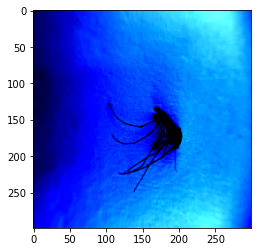

In [ ]:
plt.imshow(torch.permute(x, (1, 2, 0)))

In [ ]:
from torch.utils.data import DataLoader,WeightedRandomSampler

target_list = torch.tensor(train_dataset.labels)
class_count = np.array([len(np.where(train_dataset.labels == t)[0]) for t in np.unique(train_dataset.labels)])
print(class_count)
class_weights = 1./torch.tensor(class_count, dtype=torch.float)
print(class_weights)
class_weights_all = class_weights[target_list]
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
    )

[1285  466  444  894  325]
tensor([0.0008, 0.0021, 0.0023, 0.0011, 0.0031])


<ipython-input-10-48237969a9b6>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_list = torch.tensor(train_dataset.labels)


In [ ]:
from torch.utils.data import DataLoader
#train_dataloader = DataLoader(train_dataset,sampler=weighted_sampler, batch_size = 32)
test_dataloader = DataLoader(test_dataset,batch_size=32, shuffle=False)

In [ ]:
for i, (data, target) in enumerate(train_dataloader):
    print("batch index {}, 0/1: {}/{}/{}/{}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0]),
        len(np.where(target.numpy() == 2)[0]),
        len(np.where(target.numpy() == 3)[0]),
        len(np.where(target.numpy() == 4)[0])))

batch index 0, 0/1: 0/8/12/8/4
batch index 1, 0/1: 6/10/5/7/4
batch index 2, 0/1: 5/8/3/11/5
batch index 3, 0/1: 10/4/3/9/6
batch index 4, 0/1: 6/7/7/7/5
batch index 5, 0/1: 8/7/7/4/6
batch index 6, 0/1: 8/6/7/4/7
batch index 7, 0/1: 8/5/5/6/8
batch index 8, 0/1: 7/6/5/7/7
batch index 9, 0/1: 7/8/7/4/6
batch index 10, 0/1: 5/9/3/6/9
batch index 11, 0/1: 6/5/4/7/10
batch index 12, 0/1: 4/7/10/7/4
batch index 13, 0/1: 5/10/10/2/5
batch index 14, 0/1: 5/8/8/4/7
batch index 15, 0/1: 9/7/6/4/6
batch index 16, 0/1: 10/5/5/5/7
batch index 17, 0/1: 5/10/6/5/6
batch index 18, 0/1: 8/9/4/5/6
batch index 19, 0/1: 8/6/5/8/5
batch index 20, 0/1: 6/8/6/6/6
batch index 21, 0/1: 7/6/8/4/7
batch index 22, 0/1: 8/8/3/6/7
batch index 23, 0/1: 7/5/7/6/7
batch index 24, 0/1: 7/4/6/9/6
batch index 25, 0/1: 11/3/4/8/6
batch index 26, 0/1: 7/7/4/7/7
batch index 27, 0/1: 6/10/6/6/4
batch index 28, 0/1: 10/8/5/3/6
batch index 29, 0/1: 5/8/11/6/2
batch index 30, 0/1: 5/8/6/7/6
batch index 31, 0/1: 8/5/6/9/4
batc

In [ ]:
from torchvision import models
model = models.inception_v3(pretrained=False)
model.fc = nn.Linear(2048, 5)
model.AuxLogits.fc = nn.Linear(768, 5)
model.load_state_dict(torch.load('species/models/Species_Inception_fold2_3_with_augmentation.pt'))
model = model.to(device)

D:\anaconda3\lib\site-packages\torchvision\models\inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


In [ ]:
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 1e-4, weight_decay = 1e-5)
#optimizer = optim.SGD(model.parameters(), lr=0.0001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.15)

In [ ]:
def focal_loss(inputs, targets, reduction="mean"):
    CE_loss = F.cross_entropy(inputs, targets, reduction=reduction)
    pt = torch.exp(-CE_loss)  # prevents nans when probability 0
    F_loss = 0.25 * (1 - pt) ** 5 * CE_loss
    return F_loss.mean()

In [ ]:
def train(model):
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []

    for epoch in range (EPOCHS+1):

        correct = 0
        total = 0
        train_ave_loss = 0
        model.train()
        for batch_X, batch_Y in train_dataloader:
            
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            # zero gradient
            optimizer.zero_grad()
            # pass through
            outputs, aux_outputs = model(batch_X)

            # compute loss and back propagate
            loss1 = criterion(outputs, batch_Y)
            loss2 = criterion(aux_outputs, batch_Y)
            loss = loss1 + 0.4 * loss2
            
            loss.backward()
            # optimize
            optimizer.step()
            
            train_ave_loss += loss.data.item()
            _, predicted = outputs.max(1)
            total += batch_Y.size(0)
            correct += predicted.eq(batch_Y).sum().item()
            
        
        train_loss.append(train_ave_loss/len(train_dataloader))
        train_acc.append(100.*correct/total)
        print(f"Epoch: {epoch},Train Loss: {train_ave_loss/len(train_dataloader)} | Train Acc: {100.*correct/total} ({correct}/{total})")
    
        if epoch % 1 == 0:
        
            model.eval()
            valid_correct = 0
            valid_total = 0
            valid_ave_loss = 0
            with torch.no_grad():

                for valid_batch_X, valid_batch_Y in test_dataloader:
                    
                    valid_batch_X = valid_batch_X.to(device)
                    valid_batch_Y = valid_batch_Y.to(device)
            
                    valid_outputs = model(valid_batch_X)
                    loss = criterion(valid_outputs, valid_batch_Y)
                    valid_ave_loss += loss.data.item()
        
                    _, predicted = valid_outputs.max(1)

                    valid_correct += predicted.eq(valid_batch_Y).sum().item()
                    valid_total += valid_batch_Y.size(0)
                    
            valid_loss.append(valid_ave_loss/len(test_dataloader))
            valid_acc.append(100.*valid_correct/valid_total)
    
            print(f"Validation Loss: {valid_ave_loss/len(test_dataloader)} | Validation Acc: {100.*valid_correct/valid_total} ({valid_correct}/{valid_total})")
            #torch.save(model.state_dict(), \
            #   'drive/MyDrive/pretrain_data_path/pretrain_Inception{}.pt'.format(str(epoch//1+2)))
        
        #scheduler.step()
        
    return train_loss, valid_loss, train_acc, valid_acc

        
def test(model):
    correct = 0 
    total = 0
    model.eval()
    out = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            #loss = criterion(outputs, test_y[i].to(device).long())
            _, predicted = outputs.max(1)
            out.append(predicted.cpu().detach().numpy())

            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
    print("Accuracy:", round(correct/total, 3))
    return out

In [ ]:
train_loss, valid_loss, train_acc, valid_acc = train(model)

Epoch: 0,Train Loss: 1.0409985212522133 | Train Acc: 76.15700058582308 (2600/3414)
Validation Loss: 0.3235804381278845 | Validation Acc: 89.46731234866829 (739/826)
Epoch: 1,Train Loss: 0.3154168947834835 | Train Acc: 92.4721734036321 (3157/3414)
Validation Loss: 0.24559553404553577 | Validation Acc: 91.64648910411623 (757/826)
Epoch: 2,Train Loss: 0.23736307007547852 | Train Acc: 94.3468072642062 (3221/3414)
Validation Loss: 0.2408288872729127 | Validation Acc: 93.34140435835351 (771/826)
Epoch: 3,Train Loss: 0.16256723717446916 | Train Acc: 96.13356766256591 (3282/3414)
Validation Loss: 0.2492431266627346 | Validation Acc: 92.61501210653753 (765/826)


KeyboardInterrupt: 

In [ ]:
 out = test(model)

Accuracy: 0.901


In [ ]:
out = np.concatenate(out).ravel()

In [ ]:
out

array([2, 2, 2, ..., 4, 4, 4], dtype=int64)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       410
           1       0.85      0.76      0.80       159
           2       0.82      0.83      0.83       151
           3       0.92      0.98      0.95       252
           4       0.88      0.80      0.84        70

    accuracy                           0.90      1042
   macro avg       0.88      0.86      0.87      1042
weighted avg       0.90      0.90      0.90      1042



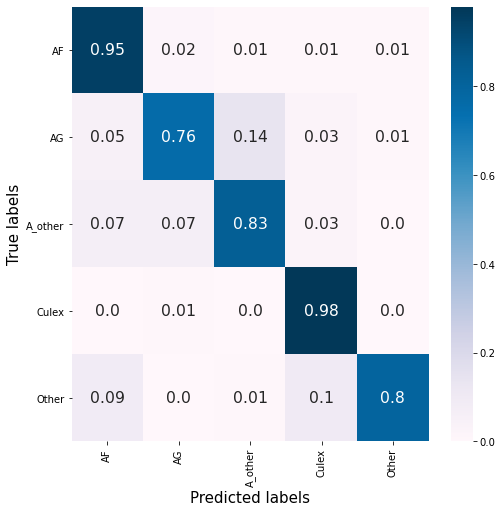

In [ ]:
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
species_all = ["AF",
        "AG",
        "A_other",
        "Culex",
        "Other"]
# print classification report
print(classification_report(test_label, out))

# make confusion matrix
conf_mat = confusion_matrix(test_label, out)
conf_mat = conf_mat / np.expand_dims(conf_mat.astype(np.float64).sum(axis=1),1)
conf_mat = np.round(conf_mat, decimals=2)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
hm = sn.heatmap(conf_mat, annot=True, ax = ax, cmap="PuBu", fmt='.2', annot_kws={"size": 35 / np.sqrt(len(conf_mat))})
ax.set_yticklabels(hm.get_yticklabels(), rotation=90)
ax.set_xlabel('Predicted labels', fontsize = 15);ax.set_ylabel('True labels', fontsize = 15); 
ax.xaxis.set_ticklabels(species_all); ax.yaxis.set_ticklabels(species_all)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.savefig('species/figures/Species_Inception_test_3_with_augmentation.jpg')
plt.show();


In [ ]:
torch.save(model.state_dict(), \
               'species/models/Species_Inception_fold2_3_with_augmentation.pt')

In [ ]:
from torchvision import models
from torch.utils.mobile_optimizer import optimize_for_mobile
model = models.inception_v3(pretrained=False)
model.fc = nn.Linear(2048, 5)
model.AuxLogits.fc = nn.Linear(768, 5)
model.load_state_dict(torch.load("species/models/Species_Inception_fold2_3_with_augmentation.pt"))
model.eval()

example = torch.rand(1, 3, 299, 299)
traced_script_module = torch.jit.trace(model, example)
optimized_scripted_module = optimize_for_mobile(traced_script_module)
#torch.jit.save(optimized_scripted_module, '../models/model.pt')
optimized_scripted_module._save_for_lite_interpreter("species/models/Species_Inception_3_with_augmentation.ptl")

D:\anaconda3\lib\site-packages\torchvision\models\inception.py:80: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '
